# Project Title: Toxic Comments Classification

#### Team Members

- Rakhat Zhussupekov
- Sadat Ahmed Ameyaw
- Veselina Bulatova
- Ahastasiia Kleschevnikova

#### Project Description: 
Online platforms often face challenges in maintaining respectful and productive discussions due to toxic comments, which can include threats, obscenity, insults, and identity-based hate. This project aims to build a machine learning model to identify and classify such toxic comments, helping platforms foster healthier interactions. The initiative builds upon research by the Conversation AI team at Jigsaw and Google, aiming to improve existing toxicity detection models.

**These issues often lead to such Business problems**:


- Online platforms are losing user engagement and participation due to toxic comments
- Manual moderation is expensive, slow, and inconsistent
- Platforms often resort to shutting down comments entirely, losing community interaction
- Existing models (like Perspective API) lack granular toxicity detection.  (only provides a single "toxicity" score, treating all forms of toxicity as a single category). This makes it difficult for platforms to selectively moderate different types of toxic content (e.g. allowing profanity but blocking threats) – This was said in the Kaggle description of the case.

And the fiancial impact of such problems if not solved include the following:

**Financial Impact of the Problem**
1.	Direct Costs: 
o	Manual moderation staff costs
o	Lost advertising revenue from reduced user engagement
o	Platform maintenance costs for basic moderation tools
2.	Indirect Costs: 
o	User churn due to toxic environment
o	Reduced content creation
o	Brand damage from toxic content
o	Legal risks from unmoderated harmful content

#### Objective:
The goal is to create a multi-label classification model capable of predicting the probability of various types of toxicity for a given comment. The model should improve upon existing tools, such as the Perspective API, by providing nuanced predictions and reducing errors.

#### Data Source: 
The dataset is sourced from Wikipedia’s talk page edits and is publicly available on [Kaggle](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/overview). It includes comments labeled for six types of toxicity:

- Toxic
- Severe toxic
- Obscene
- Threat
- Insult
- Identity hat

#### Dataset Files:

- train.csv: Contains labeled comments for training the model.
- test.csv: Unlabeled comments for testing the model predictions.
- test_labels.csv: True labels for test data (for evaluation).

#### Dataset Columns:

- id: Unique identifier for each comment.
- comment_text: Text of the comment.
- toxic, severe_toxic, obscene, threat, insult, identity_hate: Binary labels indicating the presence (1) or absence (0) of each toxicity type.

#### Scope: This project will involve:

- Exploratory Data Analysis (EDA): To understand the dataset distribution and uncover patterns in toxic comments.
- Data Preprocessing: Cleaning and preparing text data for machine learning.
- Model Development: Building and evaluating a multi-label classification model.
- Evaluation: Comparing the model's performance against existing benchmarks.



In [ ]:
# pip install contractions
# pip install spcacy

In [1]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [35]:
# pip install spacy

# If you get dependencies issues, use conda to install that particular pacakage in your terminal to avoid issues.

# Also I tried using ntlk for the tokenization I kept getting issues with the nltk punkt so use spacy and I could only install it through github:

# pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.5.0/en_core_web_sm-3.5.0.tar.gz


# Download necessary NLTK resources
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('all')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [1]:
%time

# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec, FastText, KeyedVectors
import spacy
import contractions
from sklearn.model_selection import train_test_split
import random
import os

# Load datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
test_labels = pd.read_csv('test_labels.csv')

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Preview the dataset
train_data.head(20)

# Analyze Comment Length
all_X = train_data['comment_text'].apply(lambda x: len(x))
print(f"The average comment text length is {all_X.mean()}")


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


2024-11-20 15:20:28.499152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 15:20:28.566192: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Train data shape: (159571, 8)
Test data shape: (153164, 2)
The average comment text length is 394.0732213246768


In [2]:
%time
test_data.head()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [3]:
%time
test_labels.head()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs


,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [4]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
%time
train_data.info()

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


There are total of 159571 data points and there are not missing data. Also the data has 8 columns which include 
the column id, the text and the toxic types. There are two objects  which is the id and the comment text and the 
toxic types being integers which is basically 0s and 1s 
where 1 means a comment belongs to a specific type of toxicity if this number belongs to a certain type of toxic comment.

# BASIC EDA

In [19]:
print("Check for missing values in Train dataset")
null_check=train_data.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=test_data.isnull().sum()
print(null_check)


Check for missing values in Train dataset
id                     0
comment_text           0
toxic                  0
severe_toxic           0
obscene                0
threat                 0
insult                 0
identity_hate          0
Multi_label_comment    0
word_count             0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


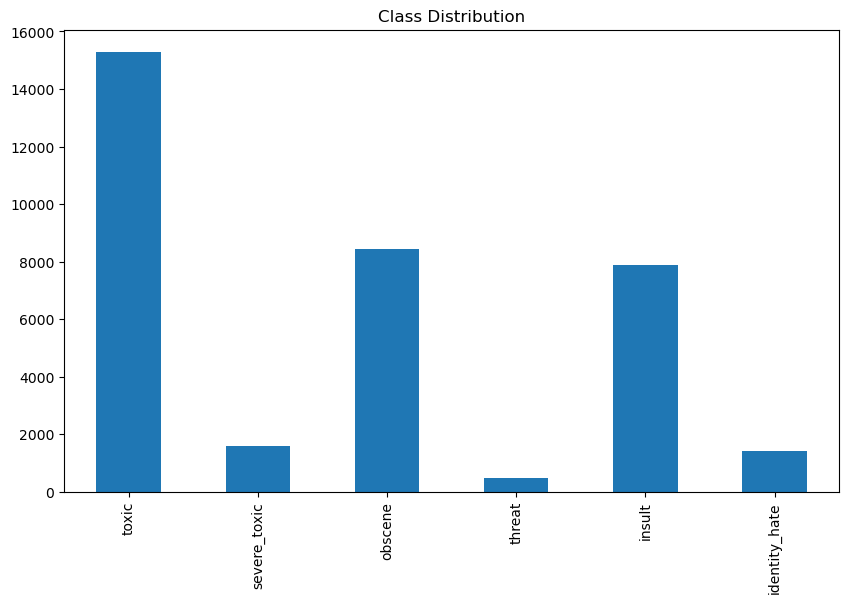

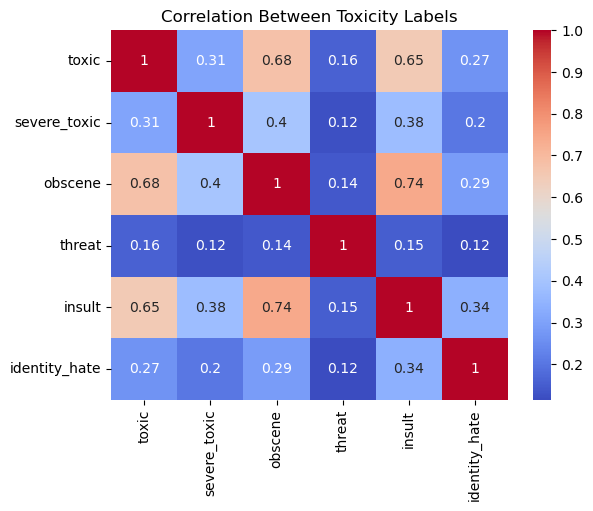

In [6]:
%time

import seaborn as sns
import matplotlib.pyplot as plt

# Class distribution
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_data[label_cols].sum().plot(kind='bar', figsize=(10, 6), title='Class Distribution')
plt.show()


# Correlation heatmap (on labels)
correlation_matrix = train_data[label_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Between Toxicity Labels')
plt.show()


##### Class Imbalance:
The dataset is highly imbalanced with some classes (e.g., 'toxic', 'obscene', 'insult') 
being more prevalent, while others (e.g., 'threat', 'identity_hate') have very few instances.
This could lead to biased model predictions favoring the majority classes.


###### Model Considerations:
- Given the imbalance, WE will consider techniques like class weighting, oversampling, or SMOTE might be necessary to improve model performance on minority classes.
- We will also Consider using metrics like F1-Score, Precision, and Recall over Accuracy for better performance evaluation.

In [7]:
# Data Cleaning (remove special characters, convert to lowercase)
def clean_comment_text(df):
    # Convert all texts to lowercase
    df['comment_text'] = df['comment_text'].str.lower()
    # Remove punctuation & special characters
    df['comment_text'] = df['comment_text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    print("Data is cleaned!")
    
clean_comment_text(train_data)

Data is cleaned!


In [9]:
%time
# Count number of each category of comment (Assuming you have label columns such as 'toxic', 'severe_toxic', etc.)
label_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']  # Adjust column names based on your dataset
category_count = {col: train_data[col].sum() for col in label_columns}
print(category_count)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs
{'toxic': 15294, 'severe_toxic': 1595, 'obscene': 8449, 'threat': 478, 'insult': 7877, 'identity_hate': 1405}


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
Multi-label comments: 9865


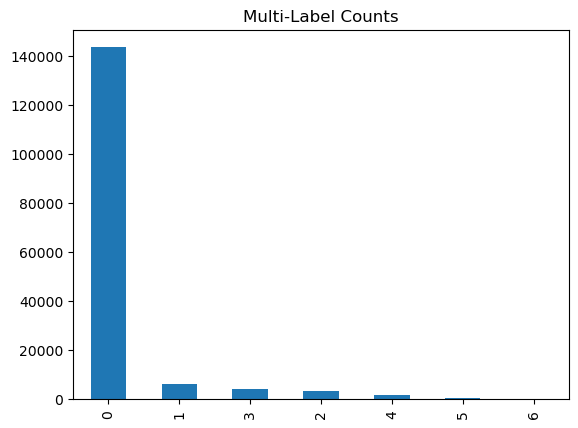

In [11]:
%time
# Multi-label comment analysis
train_data['Multi_label_comment'] = train_data[label_columns].sum(axis=1)
print(f"Multi-label comments: {(train_data['Multi_label_comment'] > 1).sum()}")
train_data['Multi_label_comment'].value_counts().plot(kind='bar', title="Multi-Label Counts")
plt.show()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


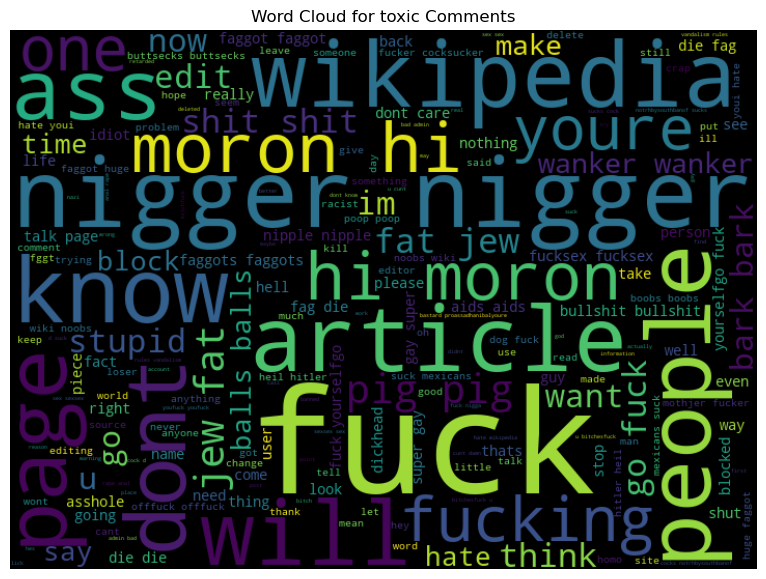

Top 20 words used in toxic comments:
             Word  Normalized Frequencies
0            fuck              100.000000
1   nigger nigger               50.186800
2       wikipedia               45.080946
3            know               44.782067
4         article               44.657534
5          people               43.212951
6            will               42.640100
7            page               39.252802
8             ass               38.206725
9            dont               37.334994
10       moron hi               36.737235
11       hi moron               36.662516
12        fucking               36.264010
13            one               35.691158
14          youre               33.972603
15        pig pig               31.108344
16        jew fat               30.734745
17        fat jew               30.535492
18      shit shit               28.518057
19          think               28.368618


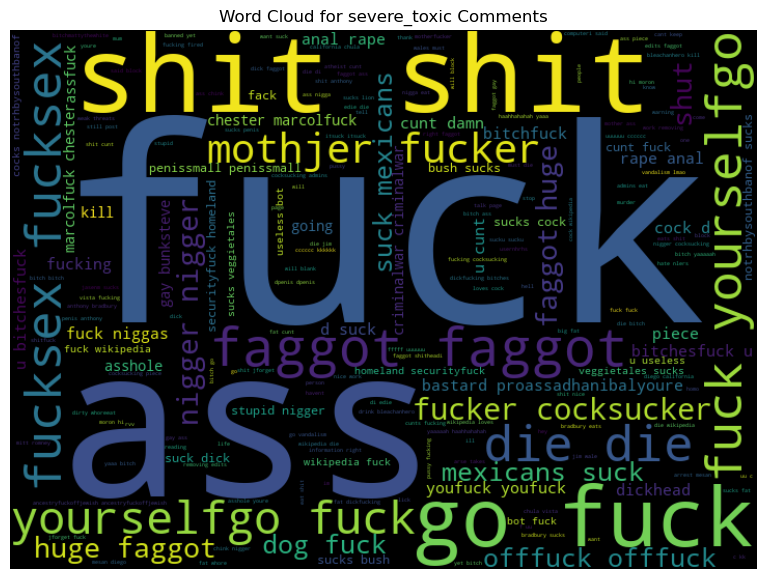

Top 20 words used in severe_toxic comments:
                            Word  Normalized Frequencies
0                           fuck              100.000000
1                            ass               55.843440
2                      shit shit               55.126792
3                        go fuck               50.937155
4                  faggot faggot               39.305402
5                        die die               34.840132
6                fucksex fucksex               34.343991
7                fuck yourselfgo               34.233738
8                yourselfgo fuck               34.233738
9                 mothjer fucker               26.957001
10             fucker cocksucker               26.901874
11                 nigger nigger               24.641676
12                   huge faggot               22.932745
13                   faggot huge               22.932745
14                          shut               22.381477
15               offfuck offfuck            

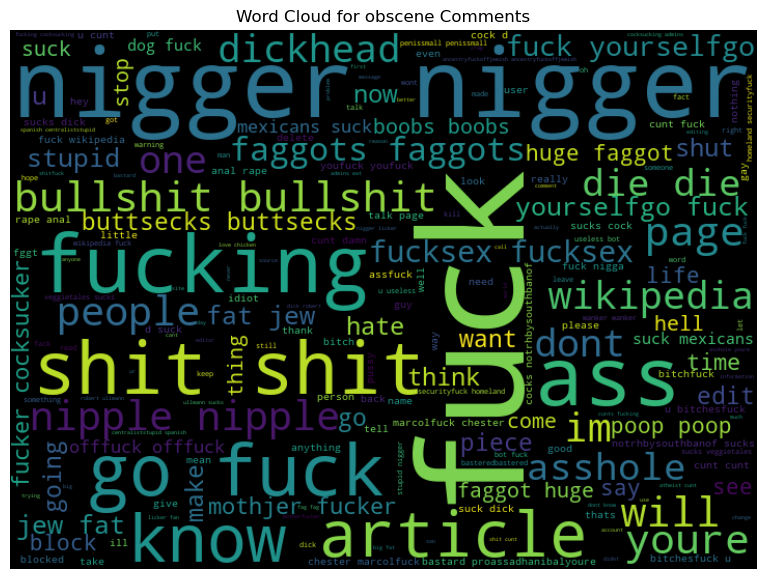

Top 20 words used in obscene comments:
                 Word  Normalized Frequencies
0                fuck              100.000000
1       nigger nigger               57.620818
2                 ass               41.321132
3             fucking               38.318559
4           shit shit               32.742351
5             go fuck               31.998856
6                know               26.594224
7             article               24.649700
8   bullshit bullshit               23.763226
9                page               23.706034
10               will               23.534458
11              youre               22.962539
12             people               21.847298
13      nipple nipple               21.818702
14                 im               21.160995
15               dont               20.560480
16          wikipedia               20.102945
17           dickhead               19.931370
18                one               19.845582
19            die die               18.30

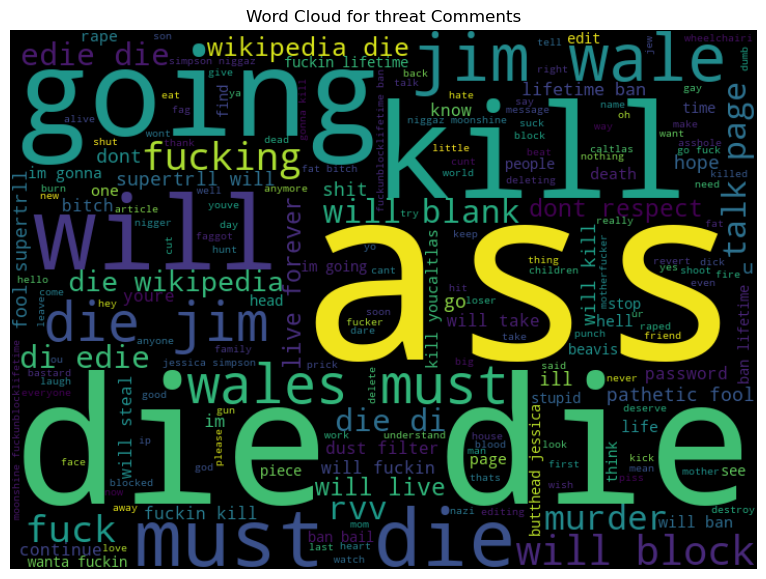

Top 20 words used in threat comments:
             Word  Normalized Frequencies
0             ass              100.000000
1         die die               83.267974
2            kill               40.130719
3           going               34.248366
4            will               23.921569
5        must die               20.784314
6        jim wale               20.653595
7      wales must               20.392157
8         die jim               20.392157
9      will block               19.477124
10        fucking               17.777778
11           fuck               16.339869
12         murder               13.986928
13      talk page               13.202614
14            rvv               12.549020
15     will blank               12.287582
16         die di               11.764706
17        di edie               11.764706
18       edie die               11.764706
19  die wikipedia               11.633987


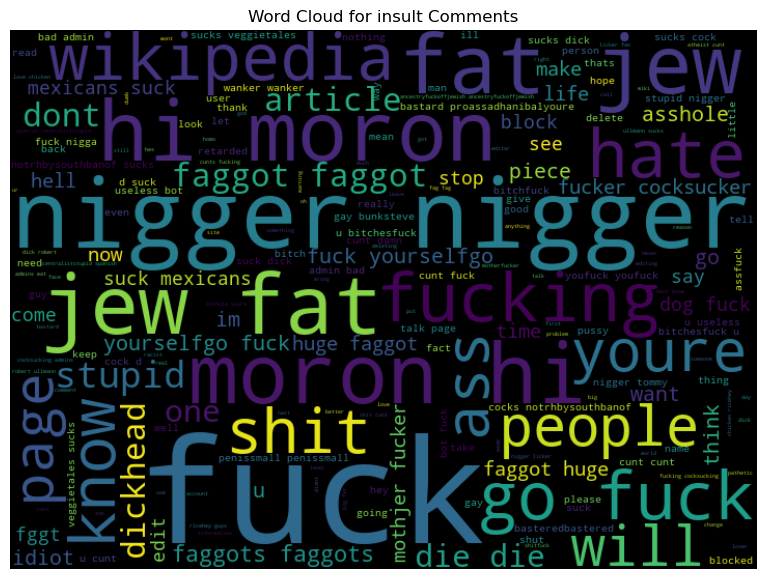

Top 20 words used in insult comments:
             Word  Normalized Frequencies
0            fuck              100.000000
1   nigger nigger               61.825426
2        moron hi               46.106483
3        hi moron               45.997827
4         jew fat               44.693951
5         fat jew               44.404201
6         fucking               41.108294
7            hate               39.985512
8         go fuck               39.659544
9       wikipedia               37.088012
10           know               35.168417
11           shit               33.538573
12            ass               32.886635
13          youre               30.242666
14         people               28.033321
15           will               27.562477
16           page               26.874321
17         stupid               26.584571
18  faggot faggot               25.932633
19           dont               25.896414


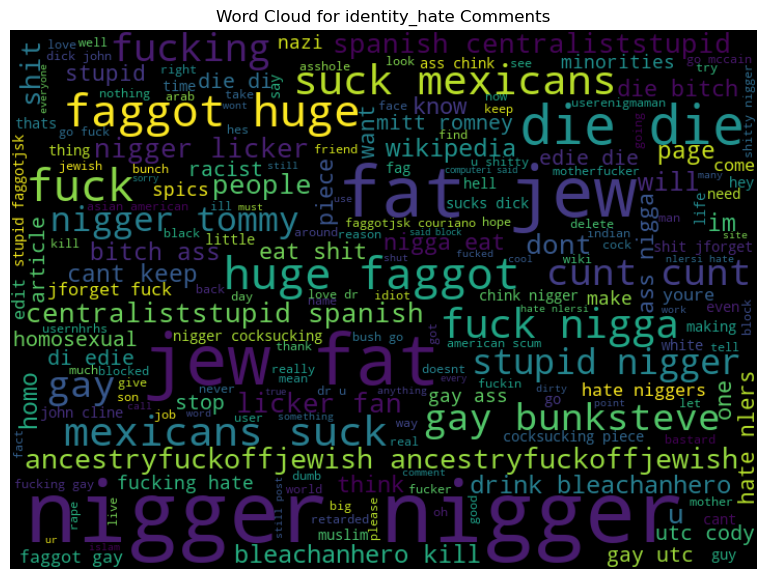

Top 20 words used in identity_hate comments:
                                           Word  Normalized Frequencies
0                                 nigger nigger              100.000000
1                                       jew fat               64.913204
2                                       fat jew               64.492372
3                                       die die               33.350868
4                                   huge faggot               21.988427
5                                   faggot huge               21.883219
6                                          fuck               21.514992
7                                 mexicans suck               18.726986
8                                 suck mexicans               18.674382
9                                    fuck nigga               17.727512
10                                      fucking               15.570752
11                                gay bunksteve               14.571278
12                 

In [12]:
%time
# Word Cloud for toxic comments
from wordcloud import WordCloud

def plot_wordcloud(df, column_name, width=720, height=520):
    if column_name not in label_columns:
        print(f"Column '{column_name}' does not exist in the DataFrame.")
        return
    
    text = ' '.join(df[df[column_name] == 1]['comment_text'])
    wordcloud = WordCloud(width=width, height=height, background_color='black').generate(text)

    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {column_name} Comments')
    plt.show()
    
 # Display Top 20 Words
    word_frequencies = wordcloud.words_
    words = pd.DataFrame(word_frequencies, index=[0]).T[:20]
    words.reset_index(inplace=True)
    words.rename(columns={0: 'Normalized Frequencies', 'index': 'Word'}, inplace=True)
    words['Normalized Frequencies'] = words['Normalized Frequencies'] * 100
    print(f'Top 20 words used in {column_name} comments:')
    print(words.head(20))

# Plot word clouds for each category
for label in label_columns:
    plot_wordcloud(train_data, label)

Displaying for toxic comments:
Top 10 bi-grams:
Top 10 (2, 2) in toxic:
           Words  Count
0        you are   4202
1       fuck you   3107
2  nigger nigger   2015
3         in the   1809
4         of the   1476
5       moron hi   1474
6       hi moron   1472
7       you fuck   1400
8         if you   1250
9        pig pig   1249
-----------------------------------------------------------------------------
Top 10 tri-grams:
Top 10 (3, 3) in toxic:
                  Words  Count
0  nigger nigger nigger   2006
1           hi moron hi   1468
2        moron hi moron   1466
3         fuck you fuck   1266
4          you fuck you   1262
5           pig pig pig   1248
6           fat jew fat   1226
7           jew fat jew   1224
8        shit shit shit   1106
9      go fuck yourself   1025
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
Displaying for severe_toxic comments:
Top 10 bi

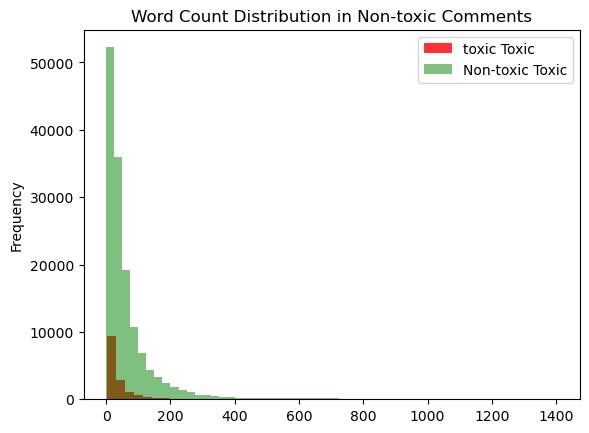

In [13]:
%time
# N-gram analysis
def get_top_ngrams(df, column_name, ngram_range, n=None):
    if column_name not in label_columns:
        print(f"Column '{column_name}' does not exist in the DataFrame.")
        return

    corpus = df[df[column_name] == 1]['comment_text']
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=n).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_ngrams = words_freq[:n]
    top_ngrams_df = pd.DataFrame(top_ngrams, columns=["Words", "Count"])
    print(f"Top {n} {ngram_range} in {column_name}:")
    print(top_ngrams_df.head(10))

# Display top bi-grams and tri-grams for each category
for label in label_columns:
    print(f"Displaying for {label} comments:")
    print(f"Top 10 bi-grams:")
    get_top_ngrams(train_data, label, ngram_range=(2, 2), n=10)
    print("-----------------------------------------------------------------------------")
    print(f"Top 10 tri-grams:")
    get_top_ngrams(train_data, label, ngram_range=(3, 3), n=10)
    print("-----------------------------------------------------------------------------")
    print("-----------------------------------------------------------------------------")

# Analysis of word count distribution
def word_count_distribution(df, label_column):
    df['word_count'] = df['comment_text'].apply(lambda x: len(x.split()))
    df[df[label_column] == 1]['word_count'].plot(kind='hist', bins=50, alpha=0.8, color='red', title=f"Word Count Distribution in {label_column} Comments")
    df[df[label_column] == 0]['word_count'].plot(kind='hist', bins=50, alpha=0.5, color='green', title=f"Word Count Distribution in Non-{label_column} Comments")
    plt.legend([f'{label_column} Toxic', f'Non-{label_column} Toxic'])
    plt.show()

# Plot word count distribution for toxic comments
word_count_distribution(train_data, 'toxic')

# TEXT PREPROCESSING 

In [20]:
import spacy
import re
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from tqdm import tqdm
tqdm.pandas()
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

class TextPreprocessor:
    """
    A class for comprehensive text preprocessing and feature extraction.
    """
    def __init__(self, remove_stopwords=True, use_lemmatization=True, use_stemming=False, 
                 expand_contractions=True, language="en_core_web_sm", custom_stopwords=None):
        self.remove_stopwords = remove_stopwords
        self.use_lemmatization = use_lemmatization
        self.use_stemming = use_stemming
        self.expand_contractions = expand_contractions
        self.nlp = spacy.load(language)
        self.stemmer = PorterStemmer()
        self.custom_stopwords = custom_stopwords or set(stopwords.words('english'))

    def preprocess_text(self, text):
        """
        Preprocess a single text string.
        """
        if not isinstance(text, str):
            return ""

        # Expand contractions
        if self.expand_contractions:
            text = contractions.fix(text)

        # Remove HTML tags
        text = re.sub(r'<.*?>', '', text)

        # Remove special characters and numbers
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)

        # Tokenization and either lemmatization or stemming
        if self.use_lemmatization and not self.use_stemming:
            doc = self.nlp(text)
            tokens = [
                token.lemma_ for token in doc
                if not self.remove_stopwords or not token.is_stop
            ]
        elif self.use_stemming:
            tokens = [
                self.stemmer.stem(word) for word in word_tokenize(text)
                if not self.remove_stopwords or word.lower() not in self.custom_stopwords
            ]
        else:
            tokens = text.split()

        return " ".join(tokens)

    def preprocess_dataframe(self, df, text_column, new_column="processed_text"):
        """
        Preprocess a DataFrame column.
        """
        tqdm.pandas(desc="Preprocessing text")
        df[new_column] = df[text_column].progress_apply(self.preprocess_text)
        return df

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
# Initialize the TextPreprocessor with the desired settings (if you want to use stemming set use_lemmatization to False and use_stem... to True)
preprocessor = TextPreprocessor(
    remove_stopwords=True,
    use_lemmatization=True,
    use_stemming=False,
    expand_contractions=False
)

In [23]:
#Trial 
sample_comment = "I'm loving this NLP course! It's amazing & worth every penny."
processed_comment = preprocessor.preprocess_text(sample_comment)
print("Original Comment:", sample_comment)
print("Processed Comment:", processed_comment)

Original Comment: I'm loving this NLP course! It's amazing & worth every penny.
Processed Comment: m love NLP course amazing   worth penny


In [ ]:
# Preprocess the 'comment_text' column in the train dataset
train_data = preprocessor.preprocess_dataframe(train_data, text_column="comment_text", new_column="processed_text")

# Preprocess the 'comment_text' column in the test dataset
test_data = preprocessor.preprocess_dataframe(test_data, text_column="comment_text", new_column="processed_text")

Preprocessing text:  65%|██████▍   | 103301/159571 [19:53<11:08, 84.18it/s] 

In [ ]:
# Preview processed data
print("Processed Train Data:")
print(train_data.head())

print("Processed Test Data:")
print(test_data.head())

# Feature extraction

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, FastText
from gensim.downloader import load
import numpy as np

def extract_features(texts, method="tfidf", params=None):
    """
    Extract text features using the specified method and parameters.
    
    Args:
        texts (list of str): The input texts.
        method (str): The feature extraction method ("tfidf", "word2vec", "glove", "fasttext").
        params (dict): Parameters for the feature extraction method.
        
    Returns:
        features: Extracted features.
        model: The model used for feature extraction.
    """
    if method == "tfidf":
        # Using TF-IDF Vectorizer
        params = params or {"max_features": 1000, "ngram_range": (1, 2), "min_df": 0.01, "max_df": 0.85}
        vectorizer = TfidfVectorizer(**params)
        features = vectorizer.fit_transform(texts)
        return features, vectorizer

    elif method == "word2vec":
        # Using Word2Vec
        tokenized_texts = [text.split() for text in texts]
        params = params or {"vector_size": 100, "window": 5, "min_count": 1}
        model = Word2Vec(sentences=tokenized_texts, **params)
        doc_vectors = [
            np.mean([model.wv[token] for token in tokens if token in model.wv] or [np.zeros(params["vector_size"])], axis=0)
            for tokens in tokenized_texts
        ]
        return np.array(doc_vectors), model

    elif method == "glove":
        # Using GloVe (pre-trained embeddings)
        model_name = params.get("model_name", "glove-wiki-gigaword-50")
        glove_model = load(model_name)
        tokenized_texts = [text.split() for text in texts]
        doc_vectors = [
            np.mean([glove_model[token] for token in tokens if token in glove_model] or [np.zeros(glove_model.vector_size)], axis=0)
            for tokens in tokenized_texts
        ]
        return np.array(doc_vectors), glove_model

    elif method == "fasttext":
        # Using FastText
        tokenized_texts = [text.split() for text in texts]
        params = params or {"vector_size": 100, "window": 5, "min_count": 1}
        model = FastText(sentences=tokenized_texts, **params)
        doc_vectors = [
            np.mean([model.wv[token] for token in tokens if token in model.wv] or [np.zeros(params["vector_size"])], axis=0)
            for tokens in tokenized_texts
        ]
        return np.array(doc_vectors), model

    else:
        raise ValueError(f"Unsupported method: {method}")
